<a href="https://colab.research.google.com/github/galaxygamerman/software-testing-course/blob/main/twitter_sentiment_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Download stopwords once
nltk.download('stopwords')

# Load the dataset
file_path = r"twitter_training.csv"
data = pd.read_csv(file_path , header = None ,names=['number' , 'Border' , 'label' , 'message']) # Adjusting the column names
data = data[['label', 'message']].dropna()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Preprocessing function
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    words = text.split()
    words = [word for word in words if word not in stopwords.words('english')]
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    return " ".join(words)

# Clean the text column
data['clean_text'] = data['message'].apply(clean_text)



In [ ]:
data['label'] = data['label'].str.lower()
print(data['label'].value_counts())
print("Unique sentiment categories:")
print(data['label'].unique())
# Step 2: Remove 'irrelevant'
data = data[~data['label'].isin(['irrelevant'])]
# Map sentiment to numbers
data['label'] = data['label'].map({'positive': 1, 'neutral': 1, 'negative': -1})

# Drop rows with NaN labels
data = data.dropna(subset=['label'])

# Count each category
print("Label distribution:")
print(data['label'].value_counts())
print("Unique sentiment categories:")
print(data['label'].unique())

label
negative      22358
positive      20655
neutral       18108
irrelevant    12875
Name: count, dtype: int64
Unique sentiment categories:
['positive' 'neutral' 'negative' 'irrelevant']
Label distribution:
label
 1    38763
-1    22358
Name: count, dtype: int64
Unique sentiment categories:
[ 1 -1]


In [ ]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data['clean_text'])
y = data['label']



              precision    recall  f1-score   support

          -1       0.86      0.73      0.79      4427
           1       0.86      0.93      0.89      7798

    accuracy                           0.86     12225
   macro avg       0.86      0.83      0.84     12225
weighted avg       0.86      0.86      0.86     12225



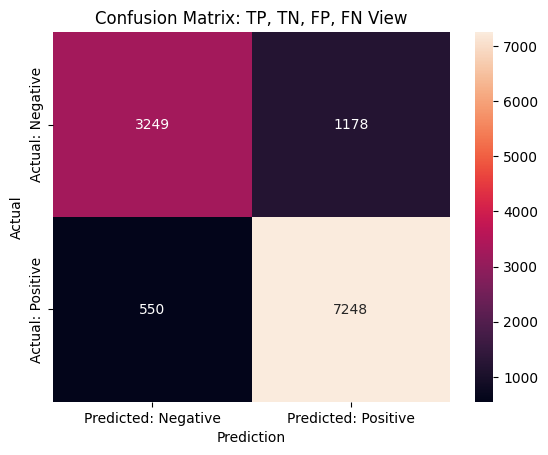

In [ ]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot with TP/TN/FP/FN in mind
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt='d',
    xticklabels=['Predicted: Negative', 'Predicted: Positive'],
    yticklabels=['Actual: Negative', 'Actual: Positive']
)
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.title("Confusion Matrix: TP, TN, FP, FN View")
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

Model Accuracy: 0.86


In [10]:
# Sample test messages
sample_messages = [
    "I love this product! Totally worth it.",
    "This is the worst service I’ve ever experienced.",
    "Not bad, could be better.",
    "What is this even supposed to be?",
    "Absolutely amazing experience!",
    "Even if i was offered a million dollars to play this game, i wouldn't.", # negative + hyperboly
    "I wish I had paid for this game, I feel bad for pirating it."  # positive + guilty
]

# Preprocess sample messages
clean_samples = [clean_text(msg) for msg in sample_messages]

# Convert to vector using the same TF-IDF vectorizer
sample_vectors = vectorizer.transform(clean_samples)

# Predict using trained model
sample_preds = model.predict(sample_vectors)

# Display results
for msg, pred in zip(sample_messages, sample_preds):
    label = {1: "Positive", -1: "Negative"}.get(pred, "Unknown")
    print(f"Message: {msg}\nPredicted Sentiment: {label}\n")


Message: I love this product! Totally worth it.
Predicted Sentiment: Positive

Message: This is the worst service I’ve ever experienced.
Predicted Sentiment: Negative

Message: Not bad, could be better.
Predicted Sentiment: Negative

Message: What is this even supposed to be?
Predicted Sentiment: Negative

Message: Absolutely amazing experience!
Predicted Sentiment: Positive

Message: Even if i was offered a million dollars to play this game, i wouldn't.
Predicted Sentiment: Positive

Message: I wish I had paid for this game, I feel bad for pirating it.
Predicted Sentiment: Negative



In [13]:
sample_tweets = [
    "Love this phone 😍🔥",                          # emoji
    "Ths prduct is amazng!",                        # misspelling
    "Oh great, another update that broke everything",  # sarcasm
    "Bad",                                           # very short
    "Good",
    "This product is absolutely, unequivocally, the worst and most disappointing experience of my life so far.",  # long + negative
    "This thing is the kind of game that even Elon would stay away from.",  # negative + joke
    "I would blow the devs just to show my appreciation for them" # inappropriate language
]
# Preprocess
cleaned_samples = [clean_text(msg) for msg in sample_tweets]

# Vectorize
sample_vecs = vectorizer.transform(cleaned_samples)

# Predict
sample_preds = model.predict(sample_vecs)

# Display results using consistent label map
for msg, pred in zip(sample_tweets, sample_preds):
    label = {1: "Positive", -1: "Negative"}.get(pred, "Unknown")
    print(f"Message: {msg}\nPredicted Sentiment: {label}\n")

Message: Love this phone 😍🔥
Predicted Sentiment: Positive

Message: Ths prduct is amazng!
Predicted Sentiment: Positive

Message: Oh great, another update that broke everything
Predicted Sentiment: Positive

Message: Bad
Predicted Sentiment: Negative

Message: Good
Predicted Sentiment: Positive

Message: This product is absolutely, unequivocally, the worst and most disappointing experience of my life so far.
Predicted Sentiment: Negative

Message: This thing is the kind of game that even Elon would stay away from.
Predicted Sentiment: Negative

Message: I would blow the devs just to show my appreciation for them
Predicted Sentiment: Positive



In [12]:
sample_noisy = [
    "Thisss phonee is amaaazing!!!",     # repeated characters
    "I l0ve thiss!!",                    # number used for letter
    "The update...ughhh broke it ag@in", # random symbols
    "!!!",
    "???",
    "Binod",                             # spam
    "Lorem ipsum dolor sit amet consectetur adipiscing elit. Quisque faucibus ex sapien vitae pellentesque sem placerat. In id cursus mi pretium tellus duis convallis. Tempus leo eu aenean sed diam urna tempor. Pulvinar vivamus fringilla lacus nec metus bibendum egestas. Iaculis massa nisl malesuada lacinia integer nunc posuere. Ut hendrerit semper vel class aptent taciti sociosqu. Ad litora torquent per conubia nostra inceptos himenaeos."
]

# Preprocess
cleaned_samples = [clean_text(msg) for msg in sample_noisy]

# Vectorize
sample_vecs = vectorizer.transform(cleaned_samples)

# Predict
sample_preds = model.predict(sample_vecs)

# Display results using consistent label map
for msg, pred in zip(sample_noisy, sample_preds):
    label = {1: "Positive", -1: "Negative"}.get(pred, "Unknown")
    print(f"Message: {msg}\nPredicted Sentiment: {label}\n")

Message: Thisss phonee is amaaazing!!!
Predicted Sentiment: Positive

Message: I l0ve thiss!!
Predicted Sentiment: Positive

Message: The update...ughhh broke it ag@in
Predicted Sentiment: Negative

Message: !!!
Predicted Sentiment: Positive

Message: ???
Predicted Sentiment: Positive

Message: Binod
Predicted Sentiment: Positive

Message: Lorem ipsum dolor sit amet consectetur adipiscing elit. Quisque faucibus ex sapien vitae pellentesque sem placerat. In id cursus mi pretium tellus duis convallis. Tempus leo eu aenean sed diam urna tempor. Pulvinar vivamus fringilla lacus nec metus bibendum egestas. Iaculis massa nisl malesuada lacinia integer nunc posuere. Ut hendrerit semper vel class aptent taciti sociosqu. Ad litora torquent per conubia nostra inceptos himenaeos.
Predicted Sentiment: Positive

